# 探讨 k 对模型的影响

In [1]:
import sys
import numpy as np
import theano
theano.config.gcc.cxxflags = "-fbracket-depth=2048"
sys.setrecursionlimit(10**8)

sys.path.append("/Users/dddd1007/project2git/discover_k_of_bayesian_learner/helper_tools")
sys.path.append("/Users/dddd1007/project2git/cognitive_control_model/scripts/bayesian_learner_model/")

import optlearner
from bl_ab import bayesian_ab_learner

In [2]:
def gen_random_routine(length, prop, trunc = True):
    con_length = length * prop
    inc_length = length - con_length

    if trunc:
        con_length = int(con_length)
        inc_length = int(inc_length)
        
#     print(con_length)
#     print(inc_length)

    con_routine = np.repeat(1, con_length)
    inc_routine = np.repeat(0, inc_length)

    total_routine = np.concatenate((con_routine, inc_routine), axis=None)
    np.random.shuffle(total_routine)

    return total_routine

def gen_env_routine(step_list, prop_list):
    zipped_list = zip(step_list, prop_list)
    
    env_routine = []
    for i in zipped_list:
        env_routine.extend(gen_random_routine(i[0], i[1]))
        
    return env_routine

## 分析思路

我们考虑 Tim Behrens 的模型可能只能反映环境的稳定性本身，却无法反映被试在这个环境中的感知是稳定的，抑或是非稳定的。也就是说，可能被试对环境信息的变化敏感与否（或者说被试的学习速率快慢）可能会影响被试的学习率是否会跟随环境信息进行调节。

假如学习率非常高，那么对于被试来讲，被试在几个 trial 中就学会了规则，那么十几个 trial 的 routine 可能对于被试来说也是 stable 的。

因此，为了让模型能够反映被试对于环境稳定性的估计，v 这个参数的应该受到被试学习率的调节。

在 Behrens 的模型中，v 参数的分布受到 k 变量的调节。k 变量反映了 v 的变化率（where K=exp(k) controls the rate of change of volatility）

在我们原有的研究当中，所发现的一个现象是，虽然被试使用 Bayesian Learner 模型可以估计出不同的环境稳定性，但是被试的 Learning Rate 是没有变化的。首先我们要考虑，是否 Bayesian Learner 模型是对环境稳定性完全敏感的，它是怎么描述环境稳定性的？

我们接下来使用 Waskom 的模型，以保证计算的正确性。我们会尝试几种组合，来看该模型说估计出来的环境稳定性，是如何随着系统的复杂度进行增长的。

### 1. 比率为 80/20，routine 步长从 10 增长到 90

In [3]:
step_list = [10, 10, 10, 10, 20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80, 100, 100, 100, 100]
prop_list = np.array(
            [80, 20, 80, 20, 80, 20, 80, 20, 80, 20, 80, 20, 80, 20, 80, 20, 80,  20,  80,  20,  80,  20,  80,  20 ]) * 0.01
env = gen_env_routine(step_list, prop_list)

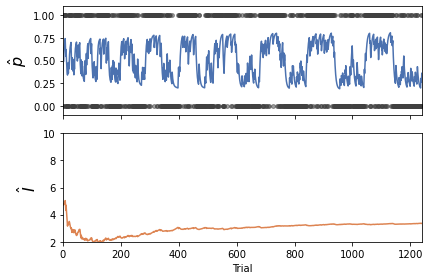

In [4]:
learner = optlearner.ProbabilityLearner()
learner.reset()
learner.fit(env)
learner.plot_history()

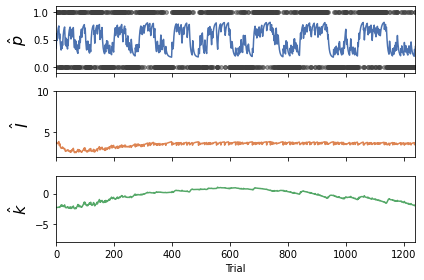

In [5]:
v_learner = optlearner.VolatilityLearner()
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

In [7]:
bayesian_ab_learner = bayesian_ab_learner(env)
bayesian_ab_learner.reset()
bayesian_ab_learner.fit()
bayesian_ab_learner.plot_history()

/Users/dddd1007/project2git/cognitive_control_model/scripts/bayesian_learner_model/bl_ab.py:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r259, r258, r257, r256, r255, r254, r253, r252, r251, r250, r249, r248, r247, r246, r245, r244, r243, r242, r241, r240, r239, r238, r237, r236, r235, r234, r233, r232, r231, r230, r229, r228, r227, r226, r225, r224, r223, r222, r221, r220, r219, r218, r217, r216, r215, r214, r213, r212, r211, r210, r209, r208, r207, r206, r205, r204, r203, r202, r201, r200, r199, r198, r197, r196, r195, r194, r193, r192, r191, r190, r189, r188, r187, r186, r185, r184, r183, r182, r181, r180, r179, r178, r177, r176, r175, r174, r173, r172, r171, r170, r169, r168, r167, r1

RecursionError: maximum recursion depth exceeded while calling a Python object

In [56]:
# reverse
step_list = step_list[::-1]
env = gen_env_routine(step_list, prop_list)

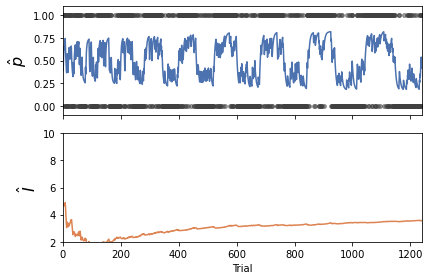

In [ ]:
learner.reset()
learner.fit(env)
learner.plot_history()

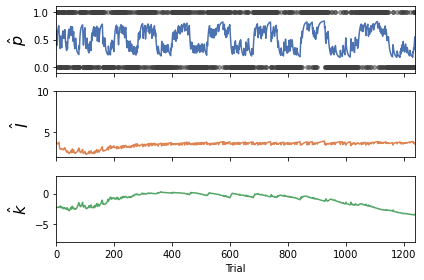

In [8]:
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

结合 Waskom 自己做的模拟来看，$\hat{i}$ 反映的是环境的稳定性。而我们可以看到，在这个模拟过程中，首先存在 $\hat{i}$ 骤变的过程，随后可以看到 i 的变化率在随着单个 block 中 trial 数的增加，而逐渐趋于平缓。这反映了 i 这个变量可能对连续变化的环境并不敏感。

同时从这个图上可以看出来，虽然 $\hat{k}$ 的取值范围会有较大的变化，但似乎对 $\hat{i}$ 并没有明显的影响。因此通过改变 $\hat{k}$ 来限制 $\hat{i}$ 的思路似乎走不通。

## 测试跨度比较大的模型

In [7]:
step_list = [10, 10, 10, 10, 60, 60, 60, 60, 100, 100, 100, 100]
prop_list = np.array(
            [80, 20, 80, 20, 80, 20, 80, 20, 80,  20,  80,  20]) * 0.01
env = gen_env_routine(step_list, prop_list)

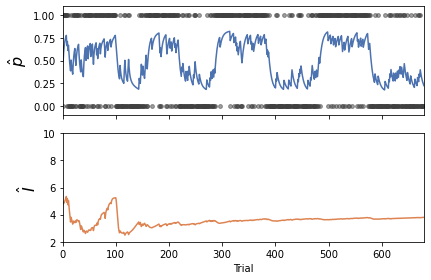

In [8]:
learner = optlearner.ProbabilityLearner()
learner.reset()
learner.fit(env)
learner.plot_history()

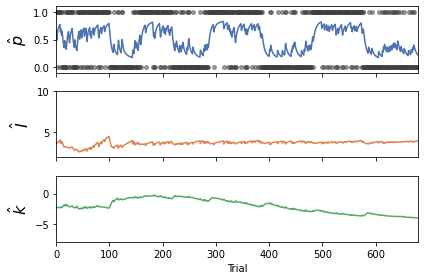

In [9]:
v_learner = optlearner.VolatilityLearner()
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

In [14]:
bayesian_ab_learner = bayesian_ab_learner(env)
bayesian_ab_learner.reset()
bayesian_ab_learner.fit()
bayesian_ab_learner.plot_history()


You can find the C code in this temporary file: /var/folders/b9/72wcckds2cb8251nj_1l8y840000gn/T/theano_compilation_error_for6ler4


Exception: ('Compilation failed (return status=1): /Users/dddd1007/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.10-64/tmp_kphrv89/mod.cpp:30692:32: fatal error: bracket nesting level exceeded maximum of 256.         if (!PyErr_Occurred()) {.                                ^. /Users/dddd1007/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.10-64/tmp_kphrv89/mod.cpp:30692:32: note: use -fbracket-depth=N to increase maximum nesting level. 1 error generated.. ', "FunctionGraph(MakeVector{dtype='float64'}(r0, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16, r17, r18, r19, r20, r21, r22, r23, r24, r25, r26, r27, r28, r29, r30, r31, r32, r33, r34, r35, r36, r37, r38, r39, r40, r41, r42, r43, r44, r45, r46, r47, r48, r49, r50, r51, r52, r53, r54, r55, r56, r57, r58, r59, r60, r61, r62, r63, r64, r65, r66, r67, r68, r69, r70, r71, r72, r73, r74, r75, r76, r77, r78, r79, r80, r81, r82, r83, r84, r85, r86, r87, r88, r89, r90, r91, r92, r93, r94, r95, r96, r97, r98, r99, r100, r101, r102, r103, r104, r105, r106, r107, r108, r109, r110, r111, r112, r113, r114, r115, r116, r117, r118, r119, r120, r121, r122, r123, r124, r125, r126, r127, r128, r129, r130, r131, r132, r133, r134, r135, r136, r137, r138, r139, r140, r141, r142, r143, r144, r145, r146, r147, r148, r149, r150, r151, r152, r153, r154, r155, r156, r157, r158, r159, r160, r161, r162, r163, r164, r165, r166, r167, r168, r169, r170, r171, r172, r173, r174, r175, r176, r177, r178, r179, r180, r181, r182, r183, r184, r185, r186, r187, r188, r189, r190, r191, r192, r193, r194, r195, r196, r197, r198, r199, r200, r201, r202, r203, r204, r205, r206, r207, r208, r209, r210, r211, r212, r213, r214, r215, r216, r217, r218, r219, r220, r221, r222, r223, r224, r225, r226, r227, r228, r229, r230, r231, r232, r233, r234, r235, r236, r237, r238, r239, r240, r241, r242, r243, r244, r245, r246, r247, r248, r249, r250, r251, r252, r253, r254, r255, r256, r257, r258, r259, r260, r261, r262, r263, r264, r265, r266, r267, r268, r269, r270, r271, r272, r273, r274, r275, r276, r277, r278, r279, r280, r281, r282, r283, r284, r285, r286, r287, r288, r289, r290, r291, r292, r293, r294, r295, r296, r297, r298, r299, r300, r301, r302, r303, r304, r305, r306, r307, r308, r309, r310, r311, r312, r313, r314, r315, r316, r317, r318, r319, r320, r321, r322, r323, r324, r325, r326, r327, r328, r329, r330, r331, r332, r333, r334, r335, r336, r337, r338, r339, r340, r341, r342, r343, r344, r345, r346, r347, r348, r349, r350, r351, r352, r353, r354, r355, r356, r357, r358, r359, r360, r361, r362, r363, r364, r365, r366, r367, r368, r369, r370, r371, r372, r373, r374, r375, r376, r377, r378, r379, r380, r381, r382, r383, r384, r385, r386, r387, r388, r389, r390, r391, r392, r393, r394, r395, r396, r397, r398, r399, r400, r401, r402, r403, r404, r405, r406, r407, r408, r409, r410, r411, r412, r413, r414, r415, r416, r417, r418, r419, r420, r421, r422, r423, r424, r425, r426, r427, r428, r429, r430, r431, r432, r433, r434, r435, r436, r437, r438, r439, r440, r441, r442, r443, r444, r445, r446, r447, r448, r449, r450, r451, r452, r453, r454, r455, r456, r457, r458, r459, r460, r461, r462, r463, r464, r465, r466, r467, r468, r469, r470, r471, r472, r473, r474, r475, r476, r477, r478, r479, r480, r481, r482, r483, r484, r485, r486, r487, r488, r489, r490, r491, r492, r493, r494, r495, r496, r497, r498, r499, r500, r501, r502, r503, r504, r505, r506, r507, r508, r509, r510, r511, r512, r513, r514, r515, r516, r517, r518, r519, r520, r521, r522, r523, r524, r525, r526, r527, r528, r529, r530, r531, r532, r533, r534, r535, r536, r537, r538, r539, r540, r541, r542, r543, r544, r545, r546, r547, r548, r549, r550, r551, r552, r553, r554, r555, r556, r557, r558, r559, r560, r561, r562, r563, r564, r565, r566, r567, r568, r569, r570, r571, r572, r573, r574, r575, r576, r577, r578, r579, r580, r581, r582, r583, r584, r585, r586, r587, r588, r589, r590, r591, r592, r593, r594, r595, r596, r597, r598, r599, r600, r601, r602, r603, r604, r605, r606, r607, r608, r609, r610, r611, r612, r613, r614, r615, r616, r617, r618, r619, r620, r621, r622, r623, r624, r625, r626, r627, r628, r629, r630, r631, r632, r633, r634, r635, r636, r637, r638, r639, r640, r641, r642, r643, r644, r645, r646, r647, r648, r649, r650, r651, r652, r653, r654, r655, r656, r657, r658, r659, r660, r661, r662, r663, r664, r665, r666, r667, r668, r669, r670, r671, r672, r673, r674, r675, r676, r677, r678, r679))")

In [62]:
# reverse
step_list = step_list[::-1]
env = gen_env_routine(step_list, prop_list)

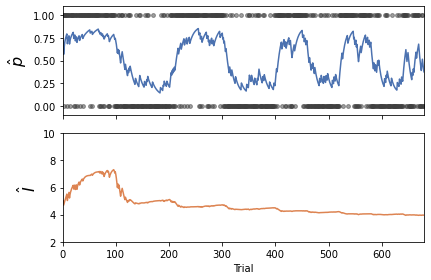

In [63]:
learner = optlearner.ProbabilityLearner()
learner.reset()
learner.fit(env)
learner.plot_history()

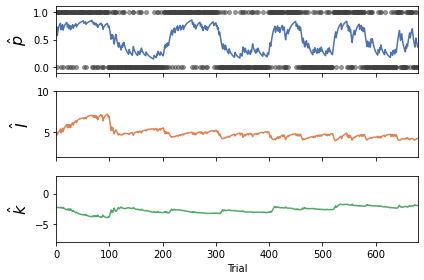

In [64]:
v_learner = optlearner.VolatilityLearner()
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

从这里的结果看出来，该模型的估计并不准确。那么为什么 Waskom 和 Tim Behrens 的模型可以估计准确呢？

先重复一下 Waskom 的测试。

In [65]:
from scipy import stats
metavol_p = np.repeat([.75, .75, .75, .25, .75, .25], 100)
metavol_y= stats.binom.rvs(1, metavol_p)

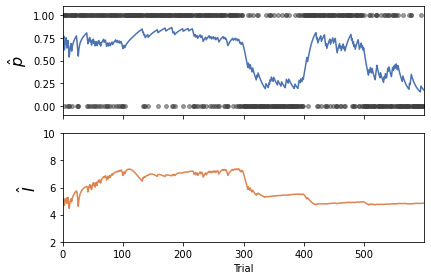

In [66]:
learner.reset()
learner.fit(metavol_y)
learner.plot_history()

首先，能够复现出 waskom 的结果。

那么，猜测 Tim Behrens 模型对 v 估计不准确有可能是以下原因：

- 模型对 80/20 的敏感性不够好，对 75/25 的敏感性更好
- Trial 数在一定范围内模型的敏感度较好，而更大的范围内就没有那么好了
- 模型设计缺陷，v 的变化只能有一次，这就是为什么之前的实验设计都是 v-s 或者 s-v 而不是 s-v-s / v-s-v 

同时，对于我们的实验中可能造成的干扰是，实验刚开始前的 v 突变可能会使得 v 在条件间看似有差异

逐项进行验证：

## 修改数列的 prop

In [67]:
step_list = [10, 10, 10, 10, 20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 65, 65, 65, 65, 100, 100, 100, 100]
prop_list = np.array(
            [75, 25, 75, 25, 75, 25, 75, 25, 75, 25, 75, 25, 75, 25, 75, 25, 75,  25,  75,  25,  75,  25,  75,  25 ]) * 0.01
env = gen_env_routine(step_list, prop_list)

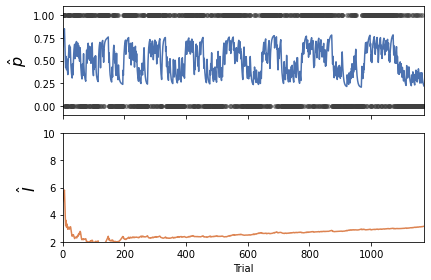

In [68]:
learner = optlearner.ProbabilityLearner()
learner.reset()
learner.fit(env)
learner.plot_history()

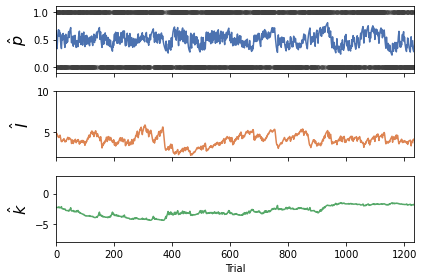

In [87]:
step_list = [10, 10, 10, 10, 20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80, 100, 100, 100, 100]
prop_list = np.array(
            [65, 35, 65, 35, 65, 35, 65, 35, 65, 35, 65, 35, 65, 35, 65, 35, 65, 35, 65, 35, 65,  35,  65,  35 ]) * 0.01
env = gen_env_routine(step_list, prop_list)
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

显然，可以发现，随着比例差异的减小，$\hat{i}$ 的取值也逐渐减小。

当然我们仍然可以看相对数值的变化。然而从初始值跳跃到稳定估计值的过程会影响后续的分析，同时也反映了初始值的设定是没有意义的。因为初始值设定为 5 的含义本身就是 50% 的绝对含义，但是如果后续只会在 1 上下波动的话，那么这个数值的含义就是不明确的。

**应该将 i 值标准化使其为绝对含义？或者 i 应该服从均匀分布？从一开始就取消它的绝对意义？**

## 测试不同的 trial 数组合对稳定性的影响

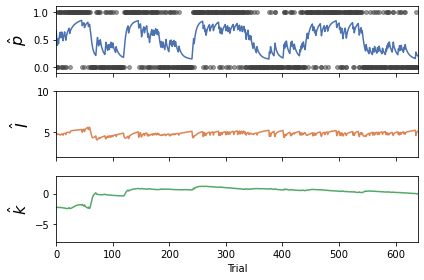

In [88]:
step_list = [60, 60, 60, 60, 100, 100, 100, 100]
prop_list = np.array(
            [80, 20, 80, 20, 80, 20, 80, 20, 80,  20,  80,  20]) * 0.01
env = gen_env_routine(step_list, prop_list)
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

这个反而还在 60 的时候上升了

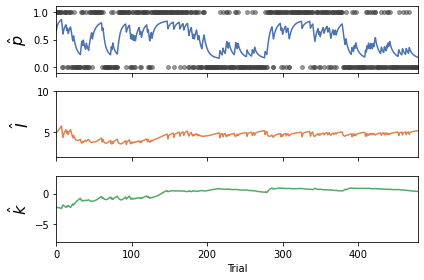

In [91]:
step_list = [20, 20, 20, 20, 100, 100, 100, 100]
prop_list = np.array(
            [80, 20, 80, 20, 80,  20,  80,  20]) * 0.01
env = gen_env_routine(step_list, prop_list)

v_learner = optlearner.VolatilityLearner()
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

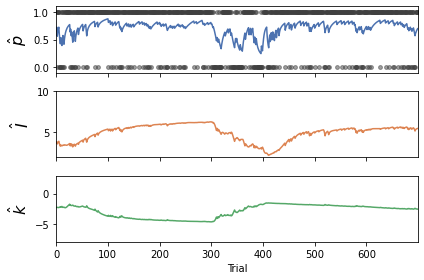

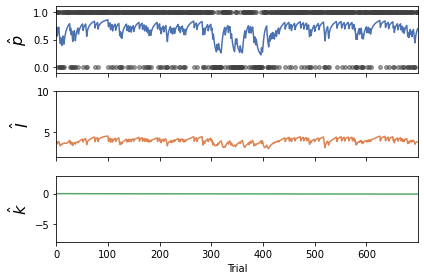

In [6]:
step_list = [100, 100, 100, 20, 20, 20, 20, 20, 100, 100, 100]
prop_list = np.array(
            [80, 80, 80, 20, 80, 20, 80,  20, 80, 80, 80]) * 0.01
env = gen_env_routine(step_list, prop_list)

v_learner = optlearner.VolatilityLearner()
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

v_learner = optlearner.VolatilityLearner(k_celling= 1.1, k_floor= 0.9)
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

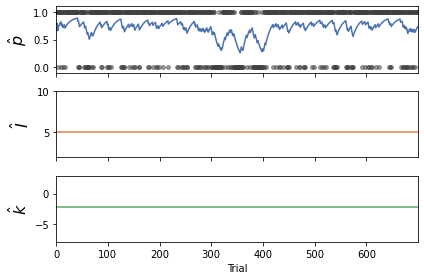

In [7]:
step_list = [100, 100, 100, 20, 20, 20, 20, 20, 100, 100, 100]
prop_list = np.array(
            [80, 80, 80, 20, 80, 20, 80,  20, 80, 80, 80]) * 0.01
env = gen_env_routine(step_list, prop_list)

v_learner = optlearner.VolatilityLearner(i_celling= 148, i_floor= 147)
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

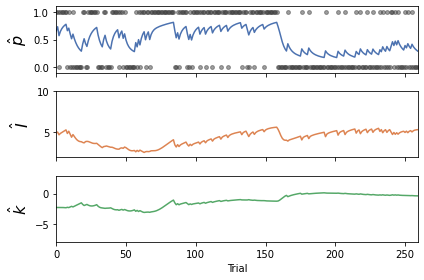

In [90]:
step_list = [10, 10, 10, 10, 10, 10, 100, 100]
prop_list = np.array(
            [80, 20, 80, 20, 80,  20,  80,  20]) * 0.01
env = gen_env_routine(step_list, prop_list)

v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

## 测试 v-s-v / s-v-s 组合

#### v-s-v

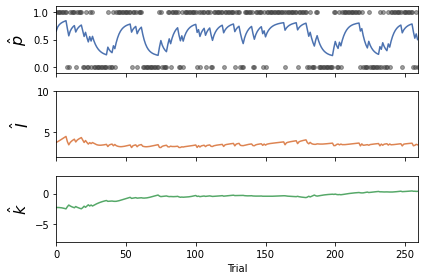

In [3]:
step_list = [20, 20, 20, 20, 100, 20, 20, 20, 20]
prop_list = np.array(
            [80, 20, 80, 20, 80,  20, 80, 20, 80]) * 0.01
env = gen_env_routine(step_list, prop_list)

v_learner = optlearner.VolatilityLearner()
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

In [7]:
bayesian_ab_learner = bayesian_ab_learner(env)
bayesian_ab_learner.reset()
bayesian_ab_learner.fit()
bayesian_ab_learner.plot_history()

/Users/dddd1007/project2git/cognitive_control_model/scripts/bayesian_learner_model/bl_ab.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.trace = pm.sample(init="adapt_diag")
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r259, r258, r257, r256, r255, r254, r253, r252, r251, r250, r249, r248, r247, r246, r245, r244, r243, r242, r241, r240, r239, r238, r237, r236, r235, r234, r233, r232, r231, r230, r229, r228, r227, r226, r225, r224, r223, r222, r221, r220, r219, r218, r217, r216, r215, r214, r213, r212, r211, r210, r209, r208, r207, r206, r205, r204, r203, r202, r201, r200, r199, r198, r197, r196, r195, r194, r193, r192, r191, r190, r189, r188, r187, r186, r185, r184, r183, r182, r181, r180, r179, r178, r177, r176, r175, r174, r17

RecursionError: maximum recursion depth exceeded while calling a Python object

#### s-v-s

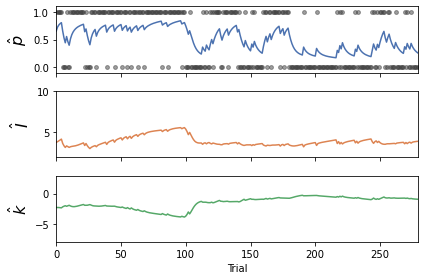

In [5]:
step_list = [100, 20, 20, 20, 20, 100]
prop_list = np.array(
            [80,  20, 80, 20, 80, 20]) * 0.01
env = gen_env_routine(step_list, prop_list)

v_learner = optlearner.VolatilityLearner()
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

我们发现，在这个模型中，连续变两次的情况下，模型没办法追踪后续的变化。

同时我们可以看到，开始是 v 或者 s 几乎决定了模型的整体形态。因此 Tim Behrens 的模型中，v-s的差异，极大的可能来源于开头的变化，而非真正对环境稳定性的评估。

这种现象出现的原因，可能是因为模型会对全局的序列进行估计。因此先从某种条件转换到另一种条件后，之前的信息会对模型造成很大的影响，就很难再转换回来。类似于一个硬币，前面全都是正面后，后面连续出现反面，再连续出现正面时，被试会此时已经有大量的信息使其维持在 50% 左右，短时间内很难再变成倾向于正面的分布。

但是这种现象本身可能并不符合个体的真实状态，因为人的工作记忆是有限的。我们只能记住最近的信息并更新信息。（这本身也是在 Tim 的论文中提出）。

**因此我们应该将模型修改为添加工作记忆的模块？**

## 使用 PyMC3 实现模型

In [54]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
p = np.repeat([.75, .75, .75, .25, .75, .25], 100)
env= stats.binom.rvs(1, p)
choose = list(map(bool, env))

observed_data = pd.DataFrame({"choose": choose, 
                              "index" : range(len(env))})

bayesian_learner = pm.Model()
with bayesian_learner:
    choose_data = pm.Data("choose_data", observed_data['choose'], dims = "index", export_index_as_coords=True)
    k  = pm.Normal("k", mu = 1, sigma = 1)
    k_ = pm.Deterministic("k_hat", pm.math.exp(k))
    v  = pm.GaussianRandomWalk("v", mu = 1, sigma = k_, dims = "index", testval = -0.7)
    r  = pm.Beta("r", mu = 0.5, sigma = pm.math.exp(v), dims = "index", testval = 0.5)
    r_rw = tt.cumsum(r)
    y  = pm.Bernoulli("y", p = r, observed = choose_data, dims = "index")
    
    step = pm.Metropolis()
    trace = pm.sample(2000, tune=1500, return_inferencedata=True, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [r]
>Metropolis: [v]
>Metropolis: [k]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 18 seconds.


0, dim: index, 600 =? 600


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [20]:
trace.posterior['r'][:,:,1]

<xarray.DataArray 'r' (chain: 4, draw: 2000)>
array([[0.33808852, 0.33808852, 0.33808852, ..., 0.95611749, 0.95611749,
        0.96185512],
       [0.94611812, 0.93585215, 0.93382768, ..., 0.99711309, 0.99663992,
        0.99590422],
       [0.9885407 , 0.98993217, 0.99001615, ..., 0.99351597, 0.99351597,
        0.99351597],
       [0.83992516, 0.83992516, 0.8580475 , ..., 0.99952609, 0.99944915,
        0.99944915]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
    index    int64 1

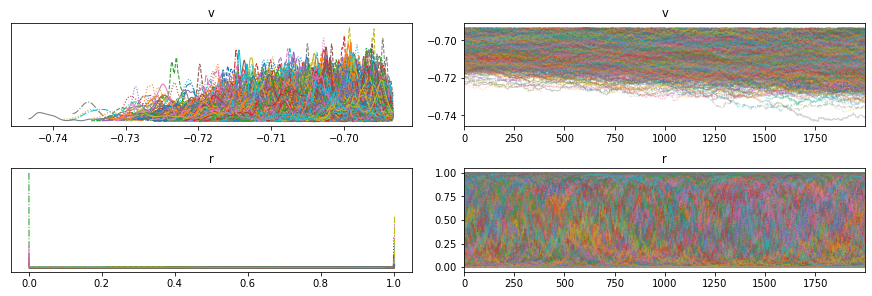

In [19]:
import arviz as az

with bayesian_learner:
    az.plot_trace(trace, var_names=["v", "r"]);

In [65]:
p = np.repeat([.75, .75, .75, .25, .75, .25], 100)
env= stats.binom.rvs(1, p)
choose = list(map(bool, env))

observed_data = pd.DataFrame({"choose": choose, 
                              "index" : range(len(env))})

bayesian_learner = pm.Model()
with bayesian_learner:
    choose_data = pm.Data("choose_data", observed_data['choose'], dims = "index", export_index_as_coords=True)
    k  = pm.Normal("k")
    k_ = pm.Deterministic("k_hat", pm.math.exp(k))
    v  = pm.GaussianRandomWalk("v", mu = 1, sigma = k_, dims = "index")
    r  = pm.GaussianRandomWalk("r", mu = 0, sigma = pm.math.exp(v), dims = "index", testval = 0.62)
    r_ = pm.Deterministic("r_", pm.math.invlogit(r), dims = "index")
    y  = pm.Bernoulli("y", logit_p = r , observed = choose_data, dims = "index")
    
    step = pm.Metropolis()
    trace = pm.sample(2000, tune=1500, return_inferencedata=True, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [r]
>Metropolis: [v]
>Metropolis: [k]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 19 seconds.


0, dim: index, 600 =? 600


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'k'}>],
       [<AxesSubplot:title={'center':'v'}>,
        <AxesSubplot:title={'center':'v'}>],
       [<AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'r'}>],
       [<AxesSubplot:title={'center':'k_hat'}>,
        <AxesSubplot:title={'center':'k_hat'}>],
       [<AxesSubplot:title={'center':'r_'}>,
        <AxesSubplot:title={'center':'r_'}>]], dtype=object)

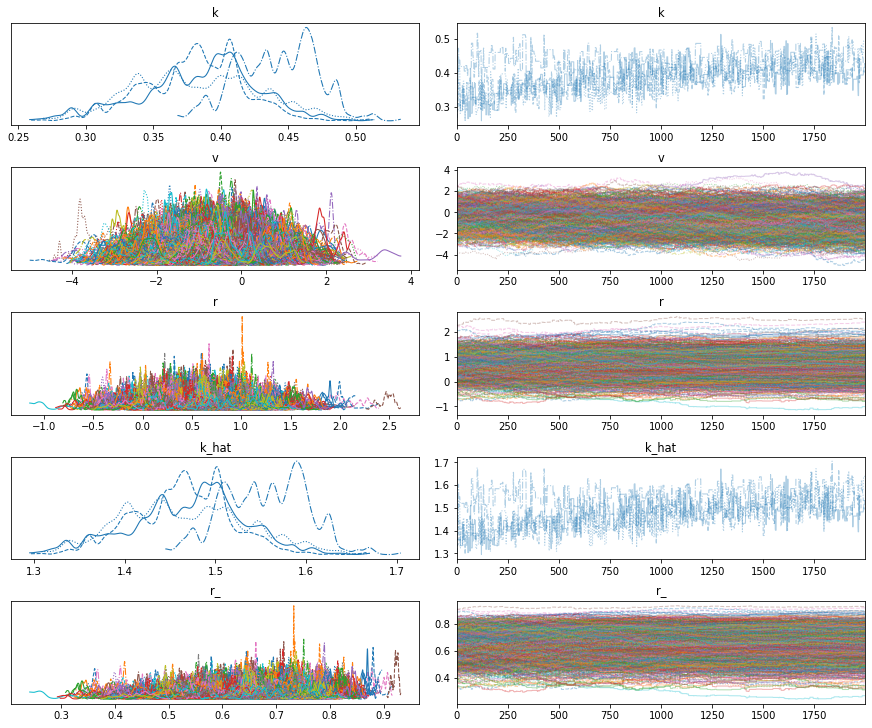

In [66]:
az.plot_trace(trace)

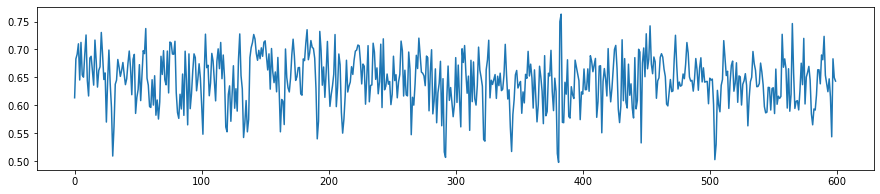

In [78]:
import matplotlib.pyplot as plt
import numpy as np

r_hat = trace.posterior.r_
r_hat_mean = r_hat.mean(axis=(0, 1))

plt.figure(figsize=(15, 3))
plt.plot(r_hat_mean)
plt.show()

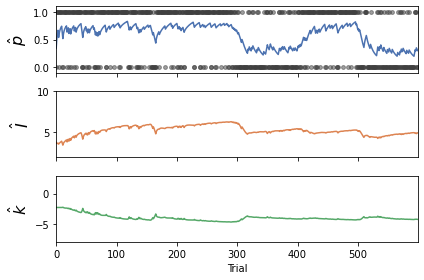

In [81]:
v_learner = optlearner.VolatilityLearner()
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

In [60]:
k_list = [1]
v_list = [1]
r_list = [0.5]

k_cap = []
v_cap = []

for observed_data in env:
    with pm.Model() as bayesian_lerner_model:
        k = pm.Normal("k", mu = k_list[-1], sigma = 1000)
        k_ = pm.Deterministic('k_cap', pm.math.exp(k))
        v = pm.Normal("v", mu = v_list[-1], sigma = k_)
        v_ = pm.Deterministic('v_cap', pm.math.exp(v))
        r = pm.Beta("r", alpha = (r_list[-1] / v_), beta = ((1 - r_list[-1]) / v_))
        y = pm.Bernoulli("y", p = r, observed = observed_data)

        trace = pm.sample()

    k_list.append(trace['k'].mean())
    v_list.append(trace['v'].mean())
    r_list.append(trace['r'].mean())
    k_cap.append(trace['k_cap'].mean())
    v_cap.append(trace['v_cap'].mean())
del (k_list[0])
del (v_list[0])
del (r_list[0])


<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, v, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 608 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34467392364857485, but should be close to 0.8. Try to increase the number of tuning steps.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.575607000795713, but should be close to 0.8. Try to increase the number of tuning steps.
There were 738 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5018665421972295, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6226163220486048, but should be close to 0.8. Try to increase the number of tuning steps.
There were 271 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6453316880723408, but should be close to 0.8. Try to increase the number of tuning steps.
There were 253 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6339763380518284, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7047120707764277, but should be close to 0.8. Try to increase the number of tuning steps.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5700637578737922, but should be close to 0.8. Try to increase the number of tuning steps.
There were 783 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.22820092145718518, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6900042643176032, but should be close to 0.8. Try to increase the number of tuning steps.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6695493645609257, but should be close to 0.8. Try to increase the number of tuning steps.
There were 363 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44670041255388576, but should be close to 0.8. Try to increase the number of tuning steps.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-6

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6350513827049439, but should be close to 0.8. Try to increase the number of tuning steps.
There were 335 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6013873784724306, but should be close to 0.8. Try to increase the number of tuning steps.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6293267004891361, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
There were 328 divergences after tuning. Increase `target_accept` or reparameterize.
There were 428 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4803098676311675, but should be close to 0.8. Try to increase the number of tuning steps.
There were 336 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6402548434235, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 417 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5301080067637387, but should be close to 0.8. Try to increase the number of tuning steps.
There were 507 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5177895325138171, but should be close to 0.8. Try to increase the number of tuning steps.
There were 414 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5304801230478702, but should be close to 0.8. Try to increase the number of tuning steps.
There were 488 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46777223008260643, but should be close

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5728729387899546, but should be close to 0.8. Try to increase the number of tuning steps.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
There were 410 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.25286080859548365, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 270 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6138929213194207, but should be close to 0.8. Try to increase the number of tuning steps.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5737398585006364, but should be close to 0.8. Try to increase the number of tuning steps.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6804956785454424, but should be close to 0.8. Try to increase the number of tuning steps.
There were 926 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.06149505725764736, but should be close

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.
There were 210 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6682066411242366, but should be close to 0.8. Try to increase the number of tuning steps.
There were 331 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.533413167902516, but should be close to 0.8. Try to increase the number of tuning steps.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass retur

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.
There were 427 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23392889973609207, but should be close to 0.8. Try to increase the number of tuning steps.
There were 295 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.620412578407932, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` obj

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5829568833588717, but should be close to 0.8. Try to increase the number of tuning steps.
There were 444 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3789006277270378, but should be close to 0.8. Try to increase the number of tuning steps.
There were 387 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.50484350972263, but should be close to 0.8. Try to increase the number of tuning steps.
There were 386 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46936520570203877, but should be close t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 185 divergences after tuning. Increase `target_accept` or reparameterize.
There were 729 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1297267578038701, but should be close to 0.8. Try to increase the number of tuning steps.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 147 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  tr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 721 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5968295704430157, but should be close to 0.8. Try to increase the number of tuning steps.
There were 264 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45624101996143873, but should be close to 0.8. Try to increase the number of tuning steps.
There were 509 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2270888131538758, but should be close to 0.8. Try to increase the number of tuning steps.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 335 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5521406256430249, but should be close to 0.8. Try to increase the number of tuning steps.
There were 434 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49901477981137804, but should be close to 0.8. Try to increase the number of tuning steps.
There were 257 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6032066792466138, but should be close to 0.8. Try to increase the number of tuning steps.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-6

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5912418311951978, but should be close to 0.8. Try to increase the number of tuning steps.
There were 276 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.582917838955258, but should be close to 0.8. Try to increase the number of tuning steps.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6869653095064638, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sam

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 786 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.12829576278717247, but should be close to 0.8. Try to increase the number of tuning steps.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6021702359449289, but should be close to 0.8. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 371 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5585887705920612, but should be close to 0.8. Try to increase the number of tuning steps.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6378074504636776, but should be close to 0.8. Try to increase the number of tuning steps.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050761083322471, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.556692757808672, but should be close to 0.8. Try to increase the number of tuning steps.
There were 663 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1770318312534825, but should be close to 0.8. Try to increase the number of tuning steps.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.576374955729115, but should be close to 0.8. Try to increase the number of tuning steps.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5309843229298377, but should be close to

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71765277306761, but should be close to 0.8. Try to increase the number of tuning steps.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6673872208334233, but should be close to 0.8. Try to increase the number of tuning steps.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 529 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3886951990437366, but should be close to 0.8. Try to increase the number of tuning steps.
There were 296 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5525830640048177, but should be close to 0.8. Try to increase the number of tuning steps.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7013939648004273, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 248 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5914776886765637, but should be close to 0.8. Try to increase the number of tuning steps.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6301716350422089, but should be close to 0.8. Try to increase the number of tuning steps.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.64202837395389, but should be close to 0.8. Try to increase the number of tuning steps.
There were 494 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3768634196775956, but should be close to

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6640044491414752, but should be close to 0.8. Try to increase the number of tuning steps.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.480858858812589, but should be close to 0.8. Try to increase the number of tuning steps.
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6453510642615888, but should be close to 0.8. Try to increase the number of tuning steps.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7183413032455371, but should be close t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2846664424909602, but should be close to 0.8. Try to increase the number of tuning steps.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.267262256679707, but should be close to 0.8. Try to increase the number of tuning steps.
There were 281 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5786524659577587, but should be close to 0.8. Try to increase the number of tuning steps.
There were 347 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.519200535181162, but should be close to 0.8. Try to increase the number of tuning steps.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6681964960140296, but should be close to

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6209165210767538, but should be close to 0.8. Try to increase the number of tuning steps.
There were 340 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5511841533595321, but should be close to 0.8. Try to increase the number of tuning steps.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6221009884240492, but should be close to 0.8. Try to increase the number of tuning steps.
There were 224 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5559899032135163, but should be close 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31882735028448683, but should be close to 0.8. Try to increase the number of tuning steps.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.26557161798062384, but should be close to 0.8. Try to increase the number of tuning steps.
There were 324 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.055772798765277326, but should be close to 0.8. Try to increase the number of tuning steps.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6378552087833734, but should be cl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 532 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3158336655298095, but should be close to 0.8. Try to increase the number of tuning steps.
There were 720 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.22279806549912004, but should be close to 0.8. Try to increase the number of tuning steps.
There were 548 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30029861666445096, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 3.4626168054546073e-22, but should be close 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6763636879765049, but should be close to 0.8. Try to increase the number of tuning steps.
There were 262 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6130224246189768, but should be close to 0.8. Try to increase the number of tuning steps.
There were 560 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3565161146252994, but should be close to 0.8. Try to increase the number of tuning steps.
There were 562 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3672107275316021, but should be close 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 556 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3169928809910442, but should be close to 0.8. Try to increase the number of tuning steps.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6750197898212202, but should be close to 0.8. Try to increase the number of tuning steps.
There were 210 divergences after tuning. Increase `target_accept` or reparameterize.
There were 410 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3973785346528308, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7125857107515245, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 378 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6023821485588059, but should be close to 0.8. Try to increase the number of tuning steps.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 954 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.011387017651867169, but should be close to 0.8. Try to increase the number of tuning steps.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6469369111390799, but should be close to 0.8. Try to increase the number of tuning steps.
There were 636 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.28824983603167126, but should be close to 0.8. Try to increase the number of tuning steps.
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6724271173420991, but should be clo

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 656 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2017856035949727, but should be close to 0.8. Try to increase the number of tuning steps.
There were 391 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5311087502812802, but should be close to 0.8. Try to increase the number of tuning steps.
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` obj

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 569 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6816024571427796, but should be close to 0.8. Try to increase the number of tuning steps.
There were 267 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5777387080638482, but should be close to 0.8. Try to increase the number of tuning steps.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.672876656070717, but should be close to 0.8. Try to increase the number of tuning steps.
There were 169 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimate

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6422048306534532, but should be close to 0.8. Try to increase the number of tuning steps.
There were 377 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4700946333807393, but should be close to 0.8. Try to increase the number of tuning steps.
There were 513 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10775944469042978, but should be close to 0.8. Try to increase the number of tuning steps.
There were 617 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5345300768813238, but should be close to 0.8. Try to increase the number of tuning steps.
There were 251 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5889232770530423, but should be close to 0.8. Try to increase the number of tuning steps.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6559316735734149, but should be close to 0.8. Try to increase the number of tuning steps.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6446020117869168, but should be close 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 479 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39511000692580006, but should be close to 0.8. Try to increase the number of tuning steps.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 533 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3209227377566445, but should be close to 0.8. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` obj

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 252 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6994597125456239, but should be close to 0.8. Try to increase the number of tuning steps.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6939918936563431, but should be close to 0.8. Try to increase the number of tuning steps.
There were 373 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.603343019276443, but should be close to 0.8. Try to increase the number of tuning steps.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6720836236463962, but should be close t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 340 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.309817334728275, but should be close to 0.8. Try to increase the number of tuning steps.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.67533044382813, but should be close to 0.8. Try to increase the number of tuning steps.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 263 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6694552242107302, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 936 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.010517806141044334, but should be close to 0.8. Try to increase the number of tuning steps.
There were 496 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40333778776055396, but should be close to 0.8. Try to increase the number of tuning steps.
There were 237 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7112706204436172, but should be close to 0.8. Try to increase the number of tuning steps.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The esti

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 475 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21865096888976643, but should be close to 0.8. Try to increase the number of tuning steps.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5442147000886398, but should be close to 0.8. Try to increase the number of tuning steps.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6084104169059579, but should be close to 0.8. Try to increase the number of tuning steps.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective sample

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 602 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.24156886391840443, but should be close to 0.8. Try to increase the number of tuning steps.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5994508704303287, but should be close to 0.8. Try to increase the number of tuning steps.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6908194786102113, but should be close to 0.8. Try to increase the number of tuning steps.
There were 642 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5896125023237733, but should be close

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 372 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5620053147326444, but should be close to 0.8. Try to increase the number of tuning steps.
There were 257 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5192422088830042, but should be close to 0.8. Try to increase the number of tuning steps.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6764977750551137, but should be close to 0.8. Try to increase the number of tuning steps.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.647572820720744, but should be close t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 294 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5706285788013511, but should be close to 0.8. Try to increase the number of tuning steps.
There were 295 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5234956390504824, but should be close to 0.8. Try to increase the number of tuning steps.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7100029413166842, but should be close to 0.8. Try to increase the number of tuning steps.
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7117594524010381, but should be close to 0.8. Try to increase the number of tuning steps.
There were 488 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3485836097848404, but should be close to 0.8. Try to increase the number of tuning steps.
There were 272 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 437 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3859247571100488, but should be close to 0.8. Try to increase the number of tuning steps.
There were 186 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44133318832420526, but should be close to 0.8. Try to increase the number of tuning steps.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5061872497060032, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 250 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6028611140766866, but should be close to 0.8. Try to increase the number of tuning steps.
There were 248 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5617226115493483, but should be close to 0.8. Try to increase the number of tuning steps.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6688235399834024, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37758419716471664, but should be close to 0.8. Try to increase the number of tuning steps.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5993084048426747, but should be close to 0.8. Try to increase the number of tuning steps.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5696286963964071, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 506 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43241682588932734, but should be close to 0.8. Try to increase the number of tuning steps.
There were 363 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5564337387539773, but should be close to 0.8. Try to increase the number of tuning steps.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6123600868240471, but should be close to 0.8. Try to increase the number of tuning steps.
There were 274 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5256638860538161, but should be close

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7004876062977449, but should be close to 0.8. Try to increase the number of tuning steps.
There were 570 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32169489305272225, but should be close to 0.8. Try to increase the number of tuning steps.
There were 346 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5486549071081164, but should be close to 0.8. Try to increase the number of tuning steps.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective sample

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 383 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44924952205706925, but should be close to 0.8. Try to increase the number of tuning steps.
There were 229 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6920335401773866, but should be close to 0.8. Try to increase the number of tuning steps.
There were 636 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.266639665993696, but should be close to 0.8. Try to increase the number of tuning steps.
There were 254 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
There were 545 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31474067791266663, but should be close to 0.8. Try to increase the number of tuning steps.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6873299587054535, but should be close to 0.8. Try to increase the number of tuning steps.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` ob

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6145553118634683, but should be close to 0.8. Try to increase the number of tuning steps.
There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5516947303170733, but should be close to 0.8. Try to increase the number of tuning steps.
There were 872 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10545363983933582, but should be close to 0.8. Try to increase the number of tuning steps.
There were 318 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5178092548632899, but should be close

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 303 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27950382459925455, but should be close to 0.8. Try to increase the number of tuning steps.
There were 285 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6355418698908785, but should be close to 0.8. Try to increase the number of tuning steps.
There were 496 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2990800206457091, but should be close to 0.8. Try to increase the number of tuning steps.
There were 760 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42470199611656556, but should be clos

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6529405234191027, but should be close to 0.8. Try to increase the number of tuning steps.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7087788930553067, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 409 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5705011084132489, but should be close to 0.8. Try to increase the number of tuning steps.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
There were 271 divergences after tuning. Increase `target_accept` or reparameterize.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 272 divergences after tuning. Increase `target_accept` or reparameterize.
There were 526 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40352107647726826, but should be close to 0.8. Try to increase the number of tuning steps.
There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
There were 574 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40443574763221035, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0,

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 274 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4342765851213481, but should be close to 0.8. Try to increase the number of tuning steps.
There were 280 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7131089488392913, but should be close to 0.8. Try to increase the number of tuning steps.
There were 291 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5746047510371555, but should be close to 0.8. Try to increase the number of tuning steps.
There were 425 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5224748169753889, but should be close 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 705 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2715844540351385, but should be close to 0.8. Try to increase the number of tuning steps.
There were 270 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5861995335941825, but should be close to 0.8. Try to increase the number of tuning steps.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6179329470453351, but should be close to 0.8. Try to increase the number of tuning steps.
There were 147 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5806104666904047, but should be close to 0.8. Try to increase the number of tuning steps.
There were 596 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6704188630444587, but should be close to 0.8. Try to increase the number of tuning steps.
There were 662 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6683185389060714, but should be close to 0.8. Try to increase the number of tuning steps.
There were 346 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37090481462967734, but should be close

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5751732628275088, but should be close to 0.8. Try to increase the number of tuning steps.
There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.604222026039148, but should be close to 0.8. Try to increase the number of tuning steps.
There were 373 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5099533535257275, but should be close to 0.8. Try to increase the number of tuning steps.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6210107840673429, but should be close t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 234 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5695086623449644, but should be close to 0.8. Try to increase the number of tuning steps.
There were 677 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2084610642015365, but should be close to 0.8. Try to increase the number of tuning steps.
There were 185 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6999376638612786, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7132918050276195, but should be close to 0.8. Try to increase the number of tuning steps.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7210825484206312, but should be close to 0.8. Try to increase the number of tuning steps.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass retu

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 344 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.566186636255816, but should be close to 0.8. Try to increase the number of tuning steps.
There were 282 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6691504993985489, but should be close to 0.8. Try to increase the number of tuning steps.
There were 210 divergences after tuning. Increase `target_accept` or reparameterize.
There were 437 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45715697751109735, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 331 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6790929216751713, but should be close to 0.8. Try to increase the number of tuning steps.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
There were 313 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6219764389696197, but should be close to 0.8. Try to increase the number of tuning steps.
There were 746 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1623940402887997, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 296 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5840145655952128, but should be close to 0.8. Try to increase the number of tuning steps.
There were 455 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39078468015606815, but should be close to 0.8. Try to increase the number of tuning steps.
There were 319 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6205282998591733, but should be close to 0.8. Try to increase the number of tuning steps.
There were 331 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5623545701567468, but should be close

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 971 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.021975848702361404, but should be close to 0.8. Try to increase the number of tuning steps.
There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6144716560824182, but should be close to 0.8. Try to increase the number of tuning steps.
There were 310 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6643474651846663, but should be close to 0.8. Try to increase the number of tuning steps.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6943885112807927, but should be clos

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
There were 488 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33218819948472567, but should be close to 0.8. Try to increase the number of tuning steps.
There were 309 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6249209593031344, but should be close to 0.8. Try to increase the number of tuning steps.
There were 281 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6902272516386347, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective sample

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 286 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4345787477525211, but should be close to 0.8. Try to increase the number of tuning steps.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5852606902118634, but should be close to 0.8. Try to increase the number of tuning steps.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5857972003271448, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sa

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
There were 469 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.20313935514500434, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  t

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5681259317651152, but should be close to 0.8. Try to increase the number of tuning steps.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7210681661047622, but should be close to 0.8. Try to increase the number of tuning steps.
There were 362 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.502428149149307, but should be close to 0.8. Try to increase the number of tuning steps.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sam

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 511 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3499313782023743, but should be close to 0.8. Try to increase the number of tuning steps.
There were 322 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5088401330484172, but should be close to 0.8. Try to increase the number of tuning steps.
There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35411798449694015, but should be close to 0.8. Try to increase the number of tuning steps.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6409580321756573, but should be close

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 184 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48602841125814894, but should be close to 0.8. Try to increase the number of tuning steps.
There were 281 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4006036367381052, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will retur

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.70690526179003, but should be close to 0.8. Try to increase the number of tuning steps.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6949022832707142, but should be close to 0.8. Try to increase the number of tuning steps.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5436391370208132, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-9

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 374 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.055484425007662874, but should be close to 0.8. Try to increase the number of tuning steps.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3020599985288363, but should be close to 0.8. Try to increase the number of tuning steps.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6415590363633651, but should be close to 0.8. Try to increase the number of tuning steps.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6782136995139287, but should be clos

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 237 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.690498902697007, but should be close to 0.8. Try to increase the number of tuning steps.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 750 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1851277806251731, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` objec

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5344369614623984, but should be close to 0.8. Try to increase the number of tuning steps.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-60-903d137f2f1b>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 336 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5778546492322655, but should be close to 0.8. Try to increase the number of tuning steps.
There were 374 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4284805540992211, but should be close to 0.8. Try to increase the number of tuning steps.
There were 732 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2007316833510581, but should be close to 0.8. Try to increase the number of tuning steps.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 432 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33895598076951095, but should be close to 0.8. Try to increase the number of tuning steps.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6311199565790967, but should be close to 0.8. Try to increase the number of tuning steps.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42688517357236205, but should be close to 0.8. Try to increase the number of tuning steps.
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7119501914850521, but should be clos

KeyboardInterrupt: 

In [61]:
r_list

[0.5,
 0.08402372686142917,
 0.8219320962152009,
 0.12097663351294423,
 0.830188999167412,
 0.9414801614236886,
 0.9716815071538862,
 0.983819094016495,
 0.45772597942190546,
 0.8628844822397437,
 0.9353138364935378,
 0.9486344428957114,
 0.9561719344322297,
 0.9626557426920375,
 0.5531133839395762,
 0.8305018854083506,
 0.9129789857619166,
 0.4131682447128253,
 0.689968976372499,
 0.8261453059597385,
 0.9077985837755246,
 0.9535268845272505,
 0.545936608982526,
 0.7444206898062983,
 0.3627633526378933,
 0.18025055688682304,
 0.5437226109984566,
 0.2782635504612458,
 0.7657420239468365,
 0.9176074035585302,
 0.9463262779913301,
 0.9679331962478314,
 0.9707564506248082,
 0.9828785287856387,
 0.9883775428428175,
 0.6008347575734352,
 0.2594111849671959,
 0.7475953268144413,
 0.909127865448812,
 0.9475372070296496,
 0.3744385361658798,
 0.11196591249425884,
 0.5816966177177999,
 0.22439283209104838,
 0.7299834186471185,
 0.9059603494537101,
 0.9490930707267325,
 0.5348625416964015,
 0.781